### Your name:

<pre> NAME HERE</pre>

### Collaborators:

<pre> Enter the name of the people you worked with if any</pre>


# Assignment for Module 4: Clustering

## Description

In this assignment you will study the electric demand (power) of clients in Portugal, during 2013 and 2014.

The data$^1$ available contains 370 time series, corresponding to the electric demand$^2$ for 370 clients, between 2011 and 2014. 

In this guided exercise you will use clustering techniques to understand the typical behaviour during 2013-2014.

#### 1. Data:
https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014#

#### 2. Electric Demand:
http://www.think-energy.net/KWvsKWH.htm


## Data Preparation

Start by downloading the data to a local directory and modify the "pathToFile" and "fileName" variables, if needed

In [118]:
pathToFile = r"C:\\temp\\"
fileName = 'LD2011_2014.txt'

In [2]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import random
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
random.seed(42)

In [119]:
# Replace "," by ".", otherwise the numbers will be in the form 2,3445 instead of 2.3445
import fileinput

with fileinput.FileInput(pathToFile+fileName, inplace=True, backup='.bak') as file:
    for line in file:
        print(line.replace(",", "."), end='')

In [4]:
# Create dataframe
import pandas as pd
data = pd.read_csv(pathToFile+fileName, sep=";", index_col=0)

### Quick data inspection

In [5]:
data.head(2)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
data.tail(2)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2014-12-31 23:45:00,1.269036,21.337127,1.737619,166.666667,85.365854,285.714286,10.17524,225.589226,64.685315,72.043011,...,246.252677,28000.0,1443.037975,909.090909,26.075619,4.095963,664.618086,146.911519,646.627566,6540.540541
2015-01-01 00:00:00,2.538071,19.914651,1.737619,178.861789,84.146341,279.761905,10.17524,249.158249,62.937063,69.892473,...,188.436831,27800.0,1409.282700,954.545455,27.379400,4.095963,628.621598,131.886477,673.020528,7135.135135


In [7]:
data.shape

(140256, 370)

#### As can be seen, the dataframe contains a row for each interval of 15 minutes between Jan 1, 2011 to Dec 31 2014. There are 370 columns corresponding 370 clients. The dataframe is indexed by the timestamp.

Since the frequency is 15 minutes, each day provides $24\times 4 = 96$ datapoints, which multiplied by 365 days and 4 years (plus 1 day in Feb 29, 2012) gives: $96 \times 365 \times 4 + 96 = 140256$, as observed in data.shape

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140256 entries, 2011-01-01 00:15:00 to 2015-01-01 00:00:00
Columns: 370 entries, MT_001 to MT_370
dtypes: float64(370)
memory usage: 397.0+ MB


In [9]:
data.describe()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
count,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,...,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000
mean,3.970785,20.768480,2.918308,82.184490,37.240309,141.227385,4.521338,191.401476,39.975354,42.205152,...,218.213701,37607.987537,1887.427366,2940.031734,65.413150,9.269709,424.262904,94.704717,625.251734,8722.355145
std,5.983965,13.272415,11.014456,58.248392,26.461327,98.439984,6.485684,121.981187,29.814595,33.401251,...,204.833532,38691.954832,1801.486488,2732.251967,65.007818,10.016782,274.337122,80.297301,380.656042,9195.155777
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.844950,0.000000,36.585366,15.853659,71.428571,0.565291,111.111111,13.986014,9.677419,...,5.710207,0.000000,0.000000,0.000000,13.037810,0.000000,0.000000,30.050083,83.944282,0.000000
50%,1.269036,24.893314,1.737619,87.398374,39.024390,157.738095,2.826456,222.222222,40.209790,40.860215,...,131.334761,24100.000000,1050.632911,2136.363636,31.290743,7.021650,525.899912,76.794658,758.064516,0.000000
75%,2.538071,29.871977,1.737619,115.853659,54.878049,205.357143,4.522329,279.461279,57.692308,61.290323,...,403.283369,54800.000000,3312.236287,5363.636364,108.213820,11.702750,627.743635,151.919866,875.366569,17783.783784
max,48.223350,115.220484,151.172893,321.138211,150.000000,535.714286,44.657999,552.188552,157.342657,198.924731,...,852.962170,192800.000000,7751.054852,12386.363636,335.071708,60.269163,1138.718174,362.270451,1549.120235,30918.918919


### Plot the 2 days of 2012 for the first 2 clients

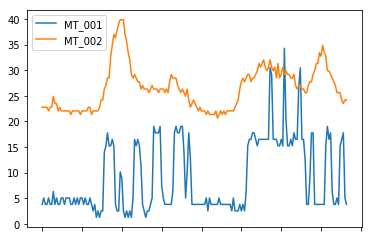

In [10]:
data_example = data.loc['2012-01-01 00:15:00':'2012-01-03 00:00:00'][['MT_001','MT_002']]
data_example.plot()
plt.show()

#### We quickly note that the main difference between the curves is the level (also seen on the means in df.describe()), so we know we will have to somehow normalize the curves, in order for the clustering technique to capture the behaviour of the consumption throughout the day, rather than the overall level.

### Data for the analysis

We focus on 2013 and 2014 because these are the years with lower number of clients having zero demand

In [11]:
data2011 = data.loc['2011-01-01 00:15:00':'2012-01-01 00:00:00']
data2012 = data.loc['2012-01-01 00:15:00':'2013-01-01 00:00:00']
data2013 = data.loc['2013-01-01 00:15:00':'2014-01-01 00:00:00']
data2014 = data.loc['2014-01-01 00:15:00':'2015-01-01 00:00:00']

In [12]:
# Check number of days
print(data2011.shape[0]/96)
print(data2012.shape[0]/96)
print(data2013.shape[0]/96)
print(data2014.shape[0]/96)

365.0
366.0
365.0
365.0


In [13]:
# See number of clients with 0 demand per year
print(sum(data2011.mean()==0))
print(sum(data2012.mean()==0))
print(sum(data2013.mean()==0))
print(sum(data2014.mean()==0))

210
37
21
1


In [14]:
clients = data2011.columns
clients_no_demand = clients[data2013.mean()==0] # clients with 0 demand
data_13_14 = data2013.append(data2014) # appending 2013 and 2014
data_13_14 = data_13_14.drop(clients_no_demand, axis=1) # drop clients with 0 demand
print(data_13_14.shape)
print(sum(data_13_14.mean()==0)) # check that there are no clients with 0 demand

(70080, 349)
0


## Getting average curves per client

In [15]:
data = data_13_14.copy() # weekdays weekends, data2011, data2012, data2013, data2014

In [16]:
data['hour'] = data.index.map(lambda x: x[11:])

In [17]:
data.head(3)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370,hour
2013-01-01 00:15:00,2.538071,22.759602,2.606429,138.211382,63.414634,255.952381,4.522329,239.057239,57.692308,78.494624,...,22300.0,886.075949,1000.000000,16.949153,6.436513,616.330114,76.794658,731.671554,8086.486486,00:15:00
2013-01-01 00:30:00,1.269036,22.759602,2.606429,138.211382,63.414634,264.880952,5.652911,228.956229,57.692308,76.344086,...,21000.0,864.978903,909.090909,18.252934,3.510825,564.530290,76.794658,727.272727,8086.486486,00:30:00
2013-01-01 00:45:00,2.538071,22.759602,2.606429,134.146341,60.975610,250.000000,5.652911,239.057239,54.195804,76.344086,...,18200.0,860.759494,840.909091,16.949153,5.851375,590.869183,68.447412,730.205279,7848.648649,00:45:00


### Getting average curves per client

In [18]:
datagrouped = data.groupby("hour")
average_curves = datagrouped.agg("mean")
average_curves.shape 

(96, 349)

#### The dataframe average_curves contains the 349 typical weekday electric demands

#### We now divide each curve by its mean, so that all curves have mean 1

In [23]:
average_curves

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
hour,,,,,,,,,,,,,,,,,,,,,
00:00:00,5.008344,26.045909,1.938755,130.551843,60.374206,191.136660,7.772366,242.027582,51.585401,54.837237,...,119.625903,36306.438356,1333.223513,1652.677460,37.831080,16.499275,676.790504,148.683880,799.235729,17333.891151
00:15:00,4.917947,25.833512,1.911381,125.863125,57.586034,179.297130,7.426996,232.516950,50.016764,53.424658,...,119.540837,32137.534247,979.064794,1443.711083,33.942955,16.580232,659.875882,155.464587,795.100028,17466.227323
00:30:00,4.984007,24.754964,1.909001,121.566990,55.476111,171.554958,7.179972,225.317098,48.843280,52.514361,...,111.557303,27249.178082,938.598925,1324.501868,31.044275,15.940589,655.911819,153.879754,777.630258,17605.301740
00:45:00,4.980530,24.656560,1.899480,117.961354,53.630137,164.452870,7.013482,218.698400,47.574001,51.150390,...,97.361963,24234.109589,837.292642,1134.433375,30.245932,15.121396,644.171167,151.146889,769.361869,17589.559422
01:00:00,4.963146,23.665699,1.863775,111.732932,52.123288,155.850457,6.843894,212.291868,46.570553,50.223892,...,91.873711,20504.383562,812.213167,1110.118306,29.617260,15.693709,640.233562,148.288243,763.943679,17574.838949
01:15:00,5.048328,22.673863,1.855444,105.451609,50.527898,151.475864,6.660368,206.858540,45.813775,49.564001,...,89.008829,19025.753425,729.350905,1086.955168,28.881427,15.136626,634.600166,140.386946,787.126903,17545.175861
01:30:00,5.037897,22.094156,1.866156,102.753647,48.989308,148.507828,6.580608,201.775748,44.951624,48.397408,...,87.170612,18240.410959,721.559447,1074.501868,28.513511,14.839247,626.789902,126.210351,762.681276,17567.108478
01:45:00,5.103957,21.868119,1.851874,100.292349,47.565987,143.052838,6.518658,196.859001,44.278667,47.420828,...,84.996040,17943.972603,714.785273,1065.317559,28.318837,14.097005,608.379136,116.145631,741.440365,17545.679378
02:00:00,5.010083,21.336152,1.795937,97.956343,46.762446,138.250163,6.431929,191.803884,43.476387,46.933274,...,84.061287,17658.219178,710.473383,1054.140722,28.231323,13.312279,595.347998,107.068859,755.338850,17532.795261


In [21]:
average_curves.mean()

MT_001        5.191112
MT_002       28.106884
MT_003        1.954785
MT_004      114.508535
MT_005       50.884390
MT_006      189.447901
MT_007        6.639154
MT_008      255.688496
MT_009       52.428693
MT_010       57.792308
MT_011       39.581855
MT_012       98.677530
MT_013       78.017033
MT_014       45.290413
MT_015       30.347607
MT_016       33.134781
MT_017       49.095412
MT_018      247.266884
MT_019        8.149079
MT_020       42.439553
MT_021      161.119342
MT_022       28.266752
MT_023        9.927714
MT_024       31.605062
MT_025      215.875915
MT_026       20.768831
MT_027       20.775256
MT_028       68.021574
MT_029       80.169608
MT_030       30.898381
              ...     
MT_340      134.155481
MT_341     1024.195989
MT_342      250.987336
MT_343      149.832102
MT_344      172.363897
MT_345     2039.896847
MT_346      284.146530
MT_348       14.382633
MT_349      192.612259
MT_350      608.687797
MT_351     1583.096588
MT_352       93.814196
MT_353     

In [ ]:
average_curves_norm = average_curves/(average_curves.mean())


In [24]:
average_curves_norm

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
hour,,,,,,,,,,,,,,,,,,,,,
00:00:00,0.964792,0.926674,0.991800,1.140106,1.186498,1.008914,1.170686,0.946572,0.983915,0.948867,...,0.414676,0.748555,0.561491,0.430085,0.471574,1.358632,1.215272,1.170441,0.974307,0.992967
00:15:00,0.947378,0.919117,0.977796,1.099159,1.131703,0.946419,1.118666,0.909376,0.953996,0.924425,...,0.414381,0.662602,0.412336,0.375704,0.423108,1.365299,1.184899,1.223818,0.969266,1.000548
00:30:00,0.960104,0.880744,0.976579,1.061641,1.090238,0.905552,1.081459,0.881217,0.931614,0.908674,...,0.386706,0.561815,0.395294,0.344682,0.386975,1.312627,1.177781,1.211343,0.947969,1.008515
00:45:00,0.959434,0.877243,0.971708,1.030153,1.053960,0.868064,1.056382,0.855331,0.907404,0.885073,...,0.337499,0.499651,0.352628,0.295219,0.377024,1.245171,1.156699,1.189829,0.937889,1.007613
01:00:00,0.956085,0.841989,0.953443,0.975761,1.024347,0.822656,1.030838,0.830275,0.888265,0.869041,...,0.318475,0.422753,0.342066,0.288892,0.369187,1.292298,1.149629,1.167326,0.931284,1.006770
01:15:00,0.972494,0.806701,0.949181,0.920906,0.992994,0.799565,1.003195,0.809026,0.873830,0.857623,...,0.308544,0.392267,0.307168,0.282864,0.360015,1.246425,1.139513,1.105127,0.959546,1.005071
01:30:00,0.970485,0.786076,0.954660,0.897345,0.962757,0.783898,0.991182,0.789147,0.857386,0.837437,...,0.302172,0.376075,0.303887,0.279623,0.355428,1.221937,1.125489,0.993529,0.929746,1.006327
01:45:00,0.983211,0.778034,0.947354,0.875850,0.934785,0.755104,0.981851,0.769917,0.844550,0.820539,...,0.294633,0.369963,0.301034,0.277233,0.353002,1.160817,1.092430,0.914299,0.903852,1.005100
02:00:00,0.965127,0.759108,0.918739,0.855450,0.918994,0.729753,0.968787,0.750147,0.829248,0.812102,...,0.291393,0.364072,0.299218,0.274324,0.351911,1.096199,1.069030,0.842847,0.920795,1.004361


#### Plot the first 2 and last 2 clients

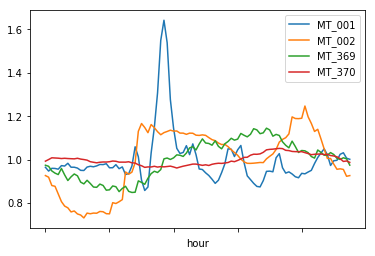

In [53]:
average_curves_norm[['MT_001','MT_002','MT_369','MT_370']].plot()
plt.show()

## Clustering Analysis on the average normizalied curves

In [26]:
X = average_curves_norm.copy()
X = np.array(X.T) # put it on the right format

In [39]:
X.shape

(349, 96)

## Exercise 1:

a. Using the functions described in Module 2, determine what a convenient number of clusters based on _intertia_ and based on _silhouette_. Justify your choice

b. Make a plot for each cluster, that includes:
    - The number of clients in the cluster (you can put this in the title of the plot)
    - All the curves in the cluster
    - The curve corresponding to the centroid of the cluster (make this curve thicker to distinguish it from the individual curves)
    
You can do 2 separate plots for each cluster if you prefer (one for the individual curves, one for the centroid)

## Solution 1:

In [32]:
# 1.a
# To find the best interia and silhouete, I used the functions and plots from Module 4 
def getInertia(X,kmeans):
    ''' This function returns the exact same value as the attribute inertia_ of kmeans'''
    inertia = 0
    for J in range(len(X)):
        inertia = inertia + np.linalg.norm(X[J] - kmeans.cluster_centers_[kmeans.labels_[J]])**2
    return inertia

def getInertia2(X,kmeans):
    ''' This function is analogous to getInertia, but with respect to the 2nd closest center, rather than closest one'''
    inertia2 = 0
    for J in range(len(X)):
        L = min(1,len(kmeans.cluster_centers_)-1) # this is just for the case where there is only 1 cluster at all
        dist_to_center = sorted([np.linalg.norm(X[J] - z)**2 for z in kmeans.cluster_centers_])[L]
        inertia2 = inertia2 + dist_to_center
    return inertia2   

In [35]:
#Computing 3 performance measures for a range of values of  k
inertias_1 = []
inertias_2 = []
silhouette_avgs = []
max_K = 15
for k in np.arange(1,max_K+1):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X)    
    inertias_1 = inertias_1 + [kmeans.inertia_]
    inertias_2 = inertias_2 + [getInertia2(X,kmeans)]
    if k>1:
        silhouette_avgs = silhouette_avgs + [silhouette_score(X, kmeans.labels_)]

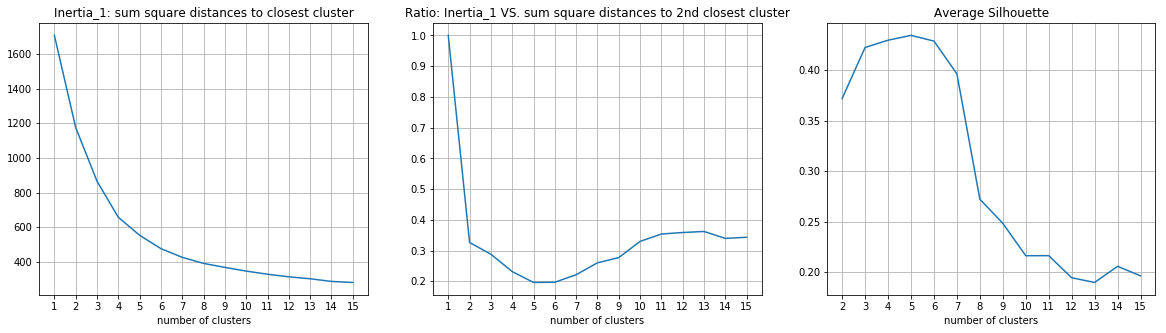

In [36]:
#Plotting performances
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
plt.title("Inertia_1: sum square distances to closest cluster")
plt.plot(np.arange(1,max_K+1),inertias_1)
plt.xticks(np.arange(1,max_K+1))
plt.xlabel('number of clusters')
plt.grid()
    
plt.subplot(1,3,2)    
plt.title("Ratio: Inertia_1 VS. sum square distances to 2nd closest cluster")
plt.plot(np.arange(1,max_K+1),np.array(inertias_1)/np.array(inertias_2))
plt.xticks(np.arange(1,max_K+1))
plt.xlabel('number of clusters')
plt.grid()

plt.subplot(1,3,3)  
plt.title("Average Silhouette")
plt.plot(np.arange(2,max_K+1), silhouette_avgs)
plt.xticks(np.arange(2,max_K+1))
plt.xlabel('number of clusters')
plt.grid()

plt.show()

#### Based on the plots above, the most connvinient number of clusters is equal to 5.

In [100]:
#Computing clusters
kmeans = KMeans(n_clusters=5, random_state=0).fit(X)  
kmeans.labels_.shape

(349,)

In [101]:
kmeans.cluster_centers_.shape

(5, 96)

In [88]:
index2=average_curves_norm.index
columns2=average_curves_norm.columns
columns2

Index(['MT_001', 'MT_002', 'MT_003', 'MT_004', 'MT_005', 'MT_006', 'MT_007',
       'MT_008', 'MT_009', 'MT_010',
       ...
       'MT_361', 'MT_362', 'MT_363', 'MT_364', 'MT_365', 'MT_366', 'MT_367',
       'MT_368', 'MT_369', 'MT_370'],
      dtype='object', length=349)

In [103]:
ar1=kmeans.labels_==0
ar1

array([False, False, False,  True,  True,  True,  True,  True,  True,
        True,  True, False, False, False, False,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True, False,  True,  True, False,  True,  True,  True, False,
        True, False,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [105]:
df1=pd.DataFrame(X.T).loc[:,kmeans.labels_==0]
df1

,3,4,5,6,7,8,9,10,15,16,...,88,105,109,142,143,145,147,331,344,346
0,1.140106,1.186498,1.008914,1.170686,0.946572,0.983915,0.948867,1.067727,1.139499,0.942227,...,1.057660,1.061366,1.225729,1.353719,1.414131,1.330476,1.763778,0.826119,1.358632,1.170441
1,1.099159,1.131703,0.946419,1.118666,0.909376,0.953996,0.924425,1.010786,1.084290,0.903545,...,0.987242,1.013051,1.189311,1.339814,1.364478,1.296742,1.763767,0.823074,1.365299,1.223818
2,1.061641,1.090238,0.905552,1.081459,0.881217,0.931614,0.908674,0.969343,1.039392,0.868223,...,0.937854,0.957617,1.178628,1.313939,1.355314,1.397739,1.777226,0.959523,1.312627,1.211343
3,1.030153,1.053960,0.868064,1.056382,0.855331,0.907404,0.885073,0.931357,0.993977,0.831421,...,0.897499,0.923288,1.159782,1.298398,1.346115,1.414333,1.796400,0.996405,1.245171,1.189829
4,0.975761,1.024347,0.822656,1.030838,0.830275,0.888265,0.869041,0.898064,0.965608,0.800586,...,0.857239,0.905054,1.163760,1.277630,1.316414,1.414344,1.794477,0.992295,1.292298,1.167326
5,0.920906,0.992994,0.799565,1.003195,0.809026,0.873830,0.857623,0.866885,0.931752,0.775767,...,0.826538,0.892654,1.116866,1.257305,1.272594,1.430518,1.794457,0.821410,1.246425,1.105127
6,0.897345,0.962757,0.783898,0.991182,0.789147,0.857386,0.837437,0.841664,0.900981,0.754609,...,0.799847,0.866163,1.088448,1.225778,1.186328,1.444814,1.788854,0.737364,1.221937,0.993529
7,0.875850,0.934785,0.755104,0.981851,0.769917,0.844550,0.820539,0.826242,0.873741,0.730919,...,0.776587,0.819299,1.082459,1.164328,1.072063,1.408566,1.813548,0.715818,1.160817,0.914299
8,0.855450,0.918994,0.729753,0.968787,0.750147,0.829248,0.812102,0.810124,0.859521,0.711189,...,0.758144,0.762100,1.071152,1.015839,0.888726,1.364512,1.887506,0.709517,1.096199,0.842847
9,0.836217,0.903958,0.725922,0.965055,0.742228,0.820569,0.802239,0.795760,0.841558,0.697852,...,0.734434,0.716223,0.950172,0.859949,0.694146,0.963017,1.694688,0.700753,0.922938,0.789775


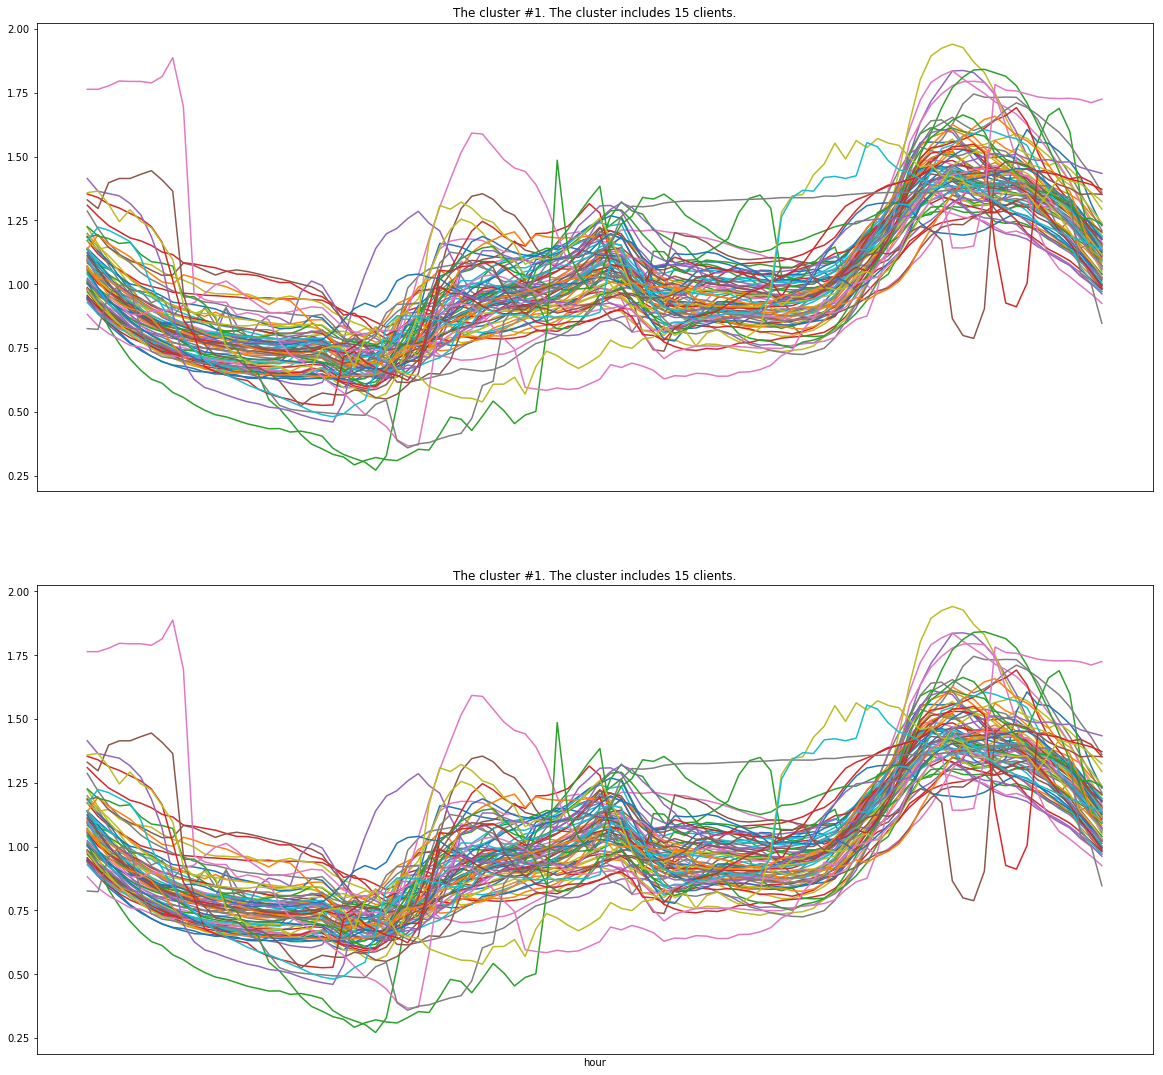

In [114]:
fig=plt.figure(figsize=(20,50))

plt.subplot(5,1,1)
plt.title("The cluster #1. The cluster includes 15 clients.")
plt.plot(df1)
plt.xticks(())
#plt.xlabel('hour')

plt.subplot(5,1,2)
plt.title("The cluster #1. The cluster includes 15 clients.")
plt.plot(df1)
plt.xticks(())
plt.xlabel('hour')


plt.show()


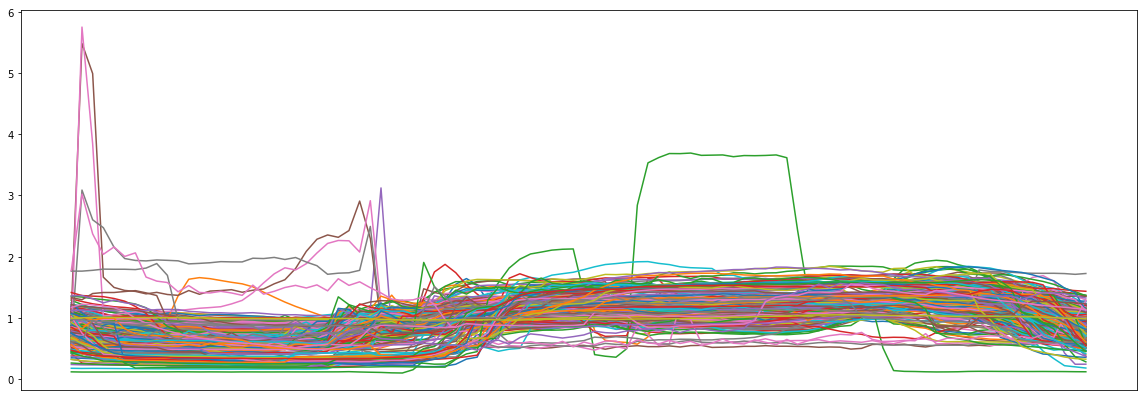

In [96]:
plt.figure(figsize=(20,7))
plt.xticks(())
#plt.yticks([])
plt.plot(average_curves_norm)
plt.show()

NameError: name 'cluster_centers_' is not defined

## Exercises 2

In this exercise you work with the daily curves of 1 single client.

First you create a list of arrays, each array containing a normalized curve for a day. The list contains 730 arrays, one for each of the days of 2013 and 2014.

a. Determine the optimal value for k-means. 

b. What are the clusters that you obtained represent?

In [415]:
client = 'MT_022'
oneClient = data_13_14[client]
X = [] # a list of arrays, each array being a normalized curve for a day
for J in range(2*365):
    X.extend([np.array(oneClient[J*96:(J+1)*96])])#/np.mean(oneClient[J*96:(J+1)*96])]) 

#### The following cell generates a list of all the days in the two years 2013-2014, which is helpful to answer part (b)

In [416]:
from datetime import date, timedelta

d1 = date(2013, 1, 1)  # start date
d2 = date(2014, 12, 31)  # end date
delta = d2 - d1         # timedelta
daysyear = []
D = {0:'mon', 1:'tue', 2:'wed', 3:'thu', 4:'fri', 5:'sat', 6:'sun'}
for i in range(delta.days + 1):
    daysyear.extend([D[(d1 + timedelta(days=i)).weekday()]+"-"+str(d1 + timedelta(days=i))])

#### The following cell shows you how to do the following: given a list L, and a list of booleans B (True, False), get the sublist of L that corresponds to the True values in B. For example if L=[1,2,3,4] and B=[False,True,True,False], then the results is [2,3]. This is also helpful for pard (b)

In [417]:
from itertools import compress
L = [1,2,3,4]
B = [False, True, True, False]
list(compress(L, B))

[2, 3]